<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/A_walk_through_latent_space_with_Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A walk through latent space with Stable Diffusion**

## Overview

Generative image models learn a "latent manifold" of the visual world:
a low-dimensional vector space where each point maps to an image.
Going from such a point on the manifold back to a displayable image
is called "decoding" -- in the Stable Diffusion model, this is handled by
the "decoder" model.

![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

This latent manifold of images is continuous and interpolative, meaning that:

1. Moving a little on the manifold only changes the corresponding image a little (continuity).
2. For any two points A and B on the manifold (i.e. any two images), it is possible
to move from A to B via a path where each intermediate point is also on the manifold (i.e.
is also a valid image). Intermediate points would be called "interpolations" between
the two starting images.

Stable Diffusion isn't just an image model, though, it's also a natural language model.
It has two latent spaces: the image representation space learned by the
encoder used during training, and the prompt latent space
which is learned using a combination of pretraining and training-time
fine-tuning.

_Latent space walking_, or _latent space exploration_, is the process of
sampling a point in latent space and incrementally changing the latent
representation. Its most common application is generating animations
where each sampled point is fed to the decoder and is stored as a
frame in the final animation.
For high-quality latent representations, this produces coherent-looking
animations. These animations can provide insight into the feature map of the
latent space, and can ultimately lead to improvements in the training
process. One such GIF is displayed below:

![Panda to Plane](/img/examples/generative/random_walks_with_stable_diffusion/panda2plane.gif)

In this guide, we will show how to take advantage of the Stable Diffusion API
in KerasCV to perform prompt interpolation and circular walks through
Stable Diffusion's visual latent manifold, as well as through
the text encoder's latent manifold.

This guide assumes the reader has a
high-level understanding of Stable Diffusion.
If you haven't already, you should start
by reading the [Stable Diffusion Tutorial](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).

To start, we import KerasCV and load up a Stable Diffusion model using the
optimizations discussed in the tutorial
[Generate images with Stable Diffusion](https://keras.io/guides/keras_cv/generate_images_with_stable_diffusion/).
Note that if you are running with a M1 Mac GPU you should not enable mixed precision.

In [ ]:
!pip install keras-cv --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.9/601.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow --upgrade
!pip install keras --upgrade

In [ ]:
import keras_cv
import keras
import matplotlib.pyplot as plt
from keras import ops
import numpy as np
import math
from PIL import Image

# Enable mixed precision
# (only do this if you have a recent NVIDIA GPU)
keras.mixed_precision.set_global_policy("mixed_float16")

# Instantiate the Stable Diffusion model
model = keras_cv.models.StableDiffusion(jit_compile=True)

## Interpolating between text prompts

In Stable Diffusion, a text prompt is first encoded into a vector,
and that encoding is used to guide the diffusion process.
The latent encoding vector has shape
77x768 (that's huge!), and when we give Stable Diffusion a text prompt, we're
generating images from just one such point on the latent manifold.

To explore more of this manifold, we can interpolate between two text encodings
and generate images at those interpolated points:

In [4]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
interpolation_steps = 5

encoding_1 = ops.squeeze(model.encode_text(prompt_1))
encoding_2 = ops.squeeze(model.encode_text(prompt_2))

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)

# Show the size of the latent manifold
print(f"Encoding shape: {encoding_1.shape}")

1356917/1356917 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
492466864/492466864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Encoding shape: (77, 768)


Once we've interpolated the encodings, we can generate images from each point.
Note that in order to maintain some stability between the resulting images we
keep the diffusion noise constant between images.

In [5]:
seed = 12345
noise = keras.random.normal((512 // 8, 512 // 8, 4), seed = seed)

images = model.generate_image(
        interpolated_encodings,
        batch_size = interpolation_steps,
        diffusion_noise = noise)

3439090152/3439090152 ━━━━━━━━━━━━━━━━━━━━ 28s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 817ms/step
198180272/198180272 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Now that we've generated some interpolated images, let's take a look at them!

Throughout this tutorial, we're going to export sequences of images as gifs so
that they can be easily viewed with some temporal context. For sequences of
images where the first and last images don't match conceptually, we rubber-band
the gif.

If you're running in Colab, you can view your own GIFs by running:

```
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")
```

In [6]:
def export_as_gif(filename, images, frames_per_second=10, rubber_band=False):
    if rubber_band:
        images += images[2:-1][::-1]
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=1000 // frames_per_second,
        loop=0,
    )


export_as_gif(
    "doggo-and-fruit-5.gif",
    [Image.fromarray(img) for img in images],
    frames_per_second=2,
    rubber_band=True,
)

In [ ]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-5.gif")

![Dog to Fruit 5](https://i.imgur.com/4ZCxZY4.gif)

The results may seem surprising. Generally, interpolating between prompts
produces coherent looking images, and often demonstrates a progressive concept
shift between the contents of the two prompts. This is indicative of a high
quality representation space, that closely mirrors the natural structure
of the visual world.

To best visualize this, we should do a much more fine-grained interpolation,
using hundreds of steps. In order to keep batch size small (so that we don't
OOM our GPU), this requires manually batching our interpolated
encodings.

In [9]:
interpolation_steps = 150
batch_size = 3
batches = interpolation_steps // batch_size

interpolated_encodings = ops.linspace(encoding_1, encoding_2, interpolation_steps)
batched_encodings = ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("doggo-and-fruit-150.gif", images, rubber_band=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 96s 524ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 534ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539

In [ ]:
from IPython.display import Image as IImage
IImage("doggo-and-fruit-150.gif")

![Dog to Fruit 150](/img/examples/generative/random_walks_with_stable_diffusion/dog2fruit150.gif)

The resulting gif shows a much clearer and more coherent shift between the two
prompts. Try out some prompts of your own and experiment!

We can even extend this concept for more than one image. For example, we can
interpolate between four prompts:

In [ ]:
prompt_1 = "A watercolor painting of a Golden Retriever at the beach"
prompt_2 = "A still life DSLR photo of a bowl of fruit"
prompt_3 = "The eiffel tower in the style of starry night"
prompt_4 = "An architectural sketch of a skyscraper"

interpolation_steps = 6
batch_size = 3
batches = (interpolation_steps**2) // batch_size

encoding_1 = ops.squeeze(model.encode_text(prompt_1))
encoding_2 = ops.squeeze(model.encode_text(prompt_2))
encoding_3 = ops.squeeze(model.encode_text(prompt_3))
encoding_4 = ops.squeeze(model.encode_text(prompt_4))

interpolated_encodings = ops.linspace(
    ops.linspace(encoding_1, encoding_2, interpolation_steps),
    ops.linspace(encoding_3, encoding_4, interpolation_steps),
    interpolation_steps,
)
interpolated_encodings = ops.reshape(
    interpolated_encodings, (interpolation_steps**2, 77, 768)
)
batched_encodings = ops.split(interpolated_encodings, batches)

images = []
for batch in range(batches):
    images.append(
        model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            diffusion_noise=noise,
        )
    )


def plot_grid(images, path, grid_size, scale=2):
    fig, axs = plt.subplots(
        grid_size, grid_size, figsize=(grid_size * scale, grid_size * scale)
    )
    fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis("off")
    for ax in axs.flat:
        ax.axis("off")

    images = images.astype(int)
    for i in range(min(grid_size * grid_size, len(images))):
        ax = axs.flat[i]
        ax.imshow(images[i].astype("uint8"))
        ax.axis("off")

    for i in range(len(images), grid_size * grid_size):
        axs.flat[i].axis("off")
        axs.flat[i].remove()

    plt.savefig(
        fname=path,
        pad_inches=0,
        bbox_inches="tight",
        transparent=False,
        dpi=60,
    )


images = np.concatenate(images)
plot_grid(images, "4-way-interpolation.jpg", interpolation_steps)

We can also interpolate while allowing diffusion noise to vary by dropping
the `diffusion_noise` parameter:

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 535ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 547ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 538ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 539ms/step


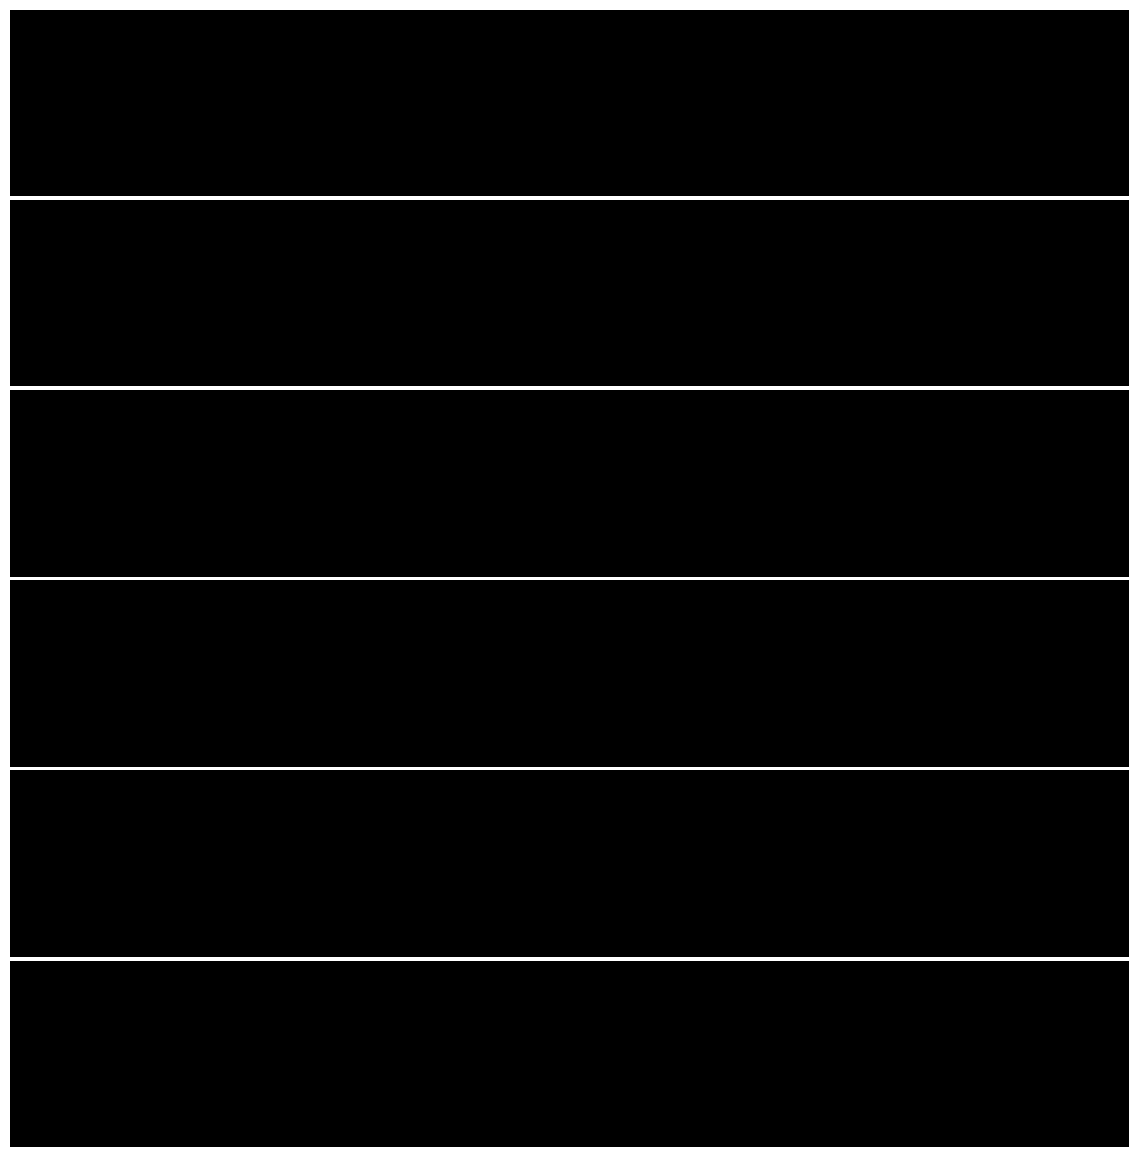

In [14]:
images = []
for batch in range(batches):
    images.append(model.generate_image(batched_encodings[batch], batch_size=batch_size))

images = np.concatenate(images)
plot_grid(images, "4-way-interpolation-varying-noise.jpg", interpolation_steps)

Next up -- let's go for some walks!

## A walk around a text prompt

Our next experiment will be to go for a walk around the latent manifold
starting from a point produced by a particular prompt.

In [15]:
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size
step_size = 0.005

encoding = ops.squeeze(
    model.encode_text("The Eiffel Tower in the style of starry night")
)
# Note that (77, 768) is the shape of the text encoding.
delta = ops.ones_like(encoding) * step_size

walked_encodings = []
for step_index in range(walk_steps):
    walked_encodings.append(encoding)
    encoding += delta
walked_encodings = ops.stack(walked_encodings)
batched_encodings = ops.split(walked_encodings, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            batched_encodings[batch],
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=noise,
        )
    ]

export_as_gif("eiffel-tower-starry-night.gif", images, rubber_band=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 547ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 541ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 540ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 540ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539

![Eiffel tower walk gif](https://i.imgur.com/9MMYtal.gif)

Perhaps unsurprisingly, walking too far from the encoder's latent manifold
produces images that look incoherent. Try it for yourself by setting
your own prompt, and adjusting `step_size` to increase or decrease the magnitude
of the walk. Note that when the magnitude of the walk gets large, the walk often
leads into areas which produce extremely noisy images.

## A circular walk through the diffusion noise space for a single prompt

Our final experiment is to stick to one prompt and explore the variety of images
that the diffusion model can produce from that prompt. We do this by controlling
the noise that is used to seed the diffusion process.

We create two noise components, `x` and `y`, and do a walk from 0 to 2π, summing
the cosine of our `x` component and the sin of our `y` component to produce noise.
Using this approach, the end of our walk arrives at the same noise inputs where
we began our walk, so we get a "loopable" result!

In [16]:
prompt = "An oil paintings of cows in a field next to a windmill in Holland"
encoding = ops.squeeze(model.encode_text(prompt))
walk_steps = 150
batch_size = 3
batches = walk_steps // batch_size

walk_noise_x = keras.random.normal(noise.shape, dtype="float64")
walk_noise_y = keras.random.normal(noise.shape, dtype="float64")

walk_scale_x = ops.cos(ops.linspace(0, 2, walk_steps) * math.pi)
walk_scale_y = ops.sin(ops.linspace(0, 2, walk_steps) * math.pi)
noise_x = ops.tensordot(walk_scale_x, walk_noise_x, axes=0)
noise_y = ops.tensordot(walk_scale_y, walk_noise_y, axes=0)
noise = ops.add(noise_x, noise_y)
batched_noise = ops.split(noise, batches)

images = []
for batch in range(batches):
    images += [
        Image.fromarray(img)
        for img in model.generate_image(
            encoding,
            batch_size=batch_size,
            num_steps=25,
            diffusion_noise=batched_noise[batch],
        )
    ]

export_as_gif("cows.gif", images)

25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 543ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 551ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 539ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 538ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 537ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 554

![Happy Cows](/img/examples/generative/random_walks_with_stable_diffusion/happycows.gif)

Experiment with your own prompts and with different values of
`unconditional_guidance_scale`!

## Conclusion

Stable Diffusion offers a lot more than just single text-to-image generation.
Exploring the latent manifold of the text encoder and the noise space of the
diffusion model are two fun ways to experience the power of this model, and
KerasCV makes it easy!